In [255]:
import os
import cv2
import numpy as np
import math
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy import interpolate

In [76]:
NUM_IMAGES=1
filename = "glass_test_30to35Deg.tiff"
file_location = "../FLIR_Camera"

In [77]:
def quad_algo(image_data):
    '''
    Extract image data from each of the 4 polarized quadrants
    '''
    tic = time.time()

    im90 = image_data[0::2, 0::2]
    im45 = image_data[0::2, 1::2]
    im135 = image_data[1::2, 0::2]
    im0 = image_data[1::2, 1::2]

    toc = time.time()
    print("Quad algorithm time ", toc - tic, "s")
    
    return im90, im45, im135, im0

In [78]:
def write_quad_image(quad_image, quad_angle, location):
    cv2.imwrite(os.path.join(location, filename+"_"+"IM{}-{}.tiff".format(quad_angle,i)), quad_image)

In [79]:
def write_glare_reduced_image(im90, im45, im135, im0, location):
    '''
    Calculate a glare reduced image by taking the lowest pixel value from each quadrant
    '''
    tic = time.time()

    glare_reduced_image = np.minimum.reduce([im90, im45, im135, im0])

    toc = time.time()
    print("Glare reduction time: ", toc - tic, "s")

    cv2.imwrite(os.path.join(location, filename+"_"+"GlareReduced-{}.tiff".format(i)), glare_reduced_image)
    
    return glare_reduced_image 

In [80]:
def calculate_Stokes_Params(im90, im45, im135, im0):
    '''
    Calculate Stokes parameters
    '''
    tic = time.time()

    im_stokes0 = im0.astype(np.float) + im90.astype(np.float)
    im_stokes1 = im0.astype(np.float) - im90.astype(np.float)
    im_stokes2 = im45.astype(np.float) - im135.astype(np.float)

    toc = time.time()
    print("Stokes time: ", toc - tic, "s")
    
    return im_stokes0, im_stokes1, im_stokes2

In [81]:
    
def calculate_DOLP(im_stokes0, im_stokes1, im_stokes2):
    '''
    Calculate DoLP
    '''
    tic = time.time()

    im_DOLP = np.divide(
        np.sqrt(np.square(im_stokes1) + np.square(im_stokes2)),
        im_stokes0,
        out=np.zeros_like(im_stokes0),
        where=im_stokes0 != 0.0,
    ).astype(np.float)

    im_DOLP = np.clip(im_DOLP, 0.0, 1.0)
    toc = time.time()
    print("DoLP time: ", toc - tic, "s")
    
    return im_DOLP

In [82]:
def normalise_DOLP(im_DOLP):
    '''
    Normalize from [0.0, 1.0] range to [0, 255] range (8 bit)
    '''
    im_DOLP_normalized = (im_DOLP * 255).astype(np.uint8)
    return im_DOLP_normalized

In [186]:
def DOLP_curve(ni, nt):
    '''
    Get the theoretical DOLP curve for unpolarized light transmission 
    from incident medium with refractive index ni to the transmission medium
    of refractive index nt
    '''
    #nt: 1.47 borosilicate glass; %1.58; %(ferrofluid emg 905);%1.333; 57.68 for EMG 905
    
    th_Brewster = np.arctan2(nt,ni)
    
    thI = np.linspace(0, th_Brewster, 200).astype(
        np.float
    )
    thT = np.arcsin(ni*np.sin(thI)/nt).astype(
        np.float
    )

    alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
    eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2

    DOLP = np.abs((alpha - eta)/(alpha + eta))
    
    fig = plt.figure(figsize=(5, 5),  facecolor='w', edgecolor='k')
    plt.plot(thI*180/np.pi, np.abs(DOLP),color='Indigo', linestyle='--', linewidth=3)
    plt.axvline(x=th_Brewster*180/np.pi, linestyle='-', linewidth=3)
    plt.xlabel("Incidence angle ($\\theta_i$) [deg]", fontsize=16)
    plt.ylabel("DOLP($\\theta_i$)", fontsize = 16)
    plt.xlim(0,90)
    plt.grid()
    plt.show()
    
    return DOLP, thI

In [240]:
def DOLP2Theta(ni, nt, im_DOLP):
    '''
    Convert from measured DOLP to theta using theoretical interpolation
    '''
    theoretical_DOLP_curve, theta_in_radians = DOLP_curve(ni, nt)

    f = interpolate.interp1d(theoretical_DOLP_curve, theta_in_radians*180/np.pi)
    im_theta = np.zeros_like(im_DOLP)
    
    DOLP_errors = []
    tic = time.time()
    for i in range(im_theta.shape[0]):
        for j in range(im_theta.shape[1]):
            try:
                im_theta[i,j] = f(im_DOLP[i,j])
            except ValueError:
                DOLP_errors.append(im_DOLP[i,j])
    
    toc = time.time()
    print("Time for DOLP2Theta conversion is : ", toc-tic, "seconds")
    return im_theta, DOLP_errors

In [241]:
def write_image(im_prefix, im_number, image, location):
    cv2.imwrite(os.path.join(location, filename+"_"+"{}-{}.tiff".format(im_prefix, im_number)), image)

In [242]:
def heatmap_from_greyscale(grey_image):
    '''
    @ param: grey_image : [0, 255] range (8 bit) image array
    '''
    # Create a heatmap from the greyscale image
    im_heatmap = cv2.applyColorMap(
        grey_image, cv2.COLORMAP_JET
    )
    return im_heatmap

In [243]:
def calculate_AOLP(im_stokes1, im_stokes2):
    '''
    Calculate AoLP
    '''
    tic = time.time()

    im_AOLP = (0.5 * np.arctan2(im_stokes2, im_stokes1)).astype(
        np.float
    )
    toc = time.time()
    print("AoLP time: ", toc - tic, "s")
    return im_AOLP

In [244]:
def normalise_AOLP(im_AOLP):
    '''
    Normalize from [-pi/2, pi/2] range to [0, 255] range (8 bit)
    '''
    im_AOLP_normalized = (
        (im_AOLP + math.pi / 2) * (255 / math.pi)
    ).astype(np.uint8)
    return im_AOLP_normalized

image_data shape is :  (2048, 2448)
Quad algorithm time  0.0 s
im90 shape is :  (1024, 1224)
Stokes time:  0.04597020149230957 s
DoLP time:  0.03497958183288574 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


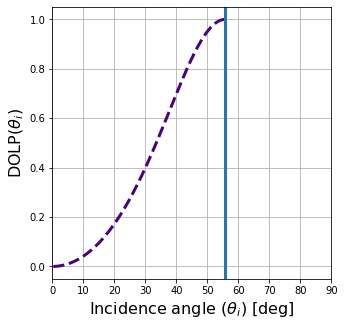

Time for DOLP2Theta conversion is :  23.246612310409546 seconds
False
AoLP time:  0.06196475028991699 s


In [245]:
for i in range(NUM_IMAGES):
    image_data = cv2.imread(os.path.join(file_location, filename).format(i))[:,:,0]
    print("image_data shape is : ", image_data.shape)
#     print(not (image_data[:,:,0]==image_data[:,:,2]).all())
    im90, im45, im135, im0 = quad_algo(image_data)
    print("im90 shape is : ", im90.shape)
    
    write_quad_image(im90, 90, file_location)
    write_quad_image(im90, 45, file_location)
    write_quad_image(im90, 135, file_location)
    write_quad_image(im90, 0, file_location)
    
    # Get Stokes vector first 3 components from 4 quad images
    im_stokes0, im_stokes1, im_stokes2 = calculate_Stokes_Params(im90, im45, im135, im0)
    
    # Get DOLP from Stokes measurements
    im_DOLP = calculate_DOLP(im_stokes0, im_stokes1, im_stokes2)
    
    # Get theta (Angle of incidence) from DOLP
    im_theta, DOLP_errors =  DOLP2Theta(1, 1.47, im_DOLP)
    print(np.array(DOLP_errors).any())
    
    # Create a heatmap from the greyscale image
    im_DOLP_normalized = normalise_DOLP(im_DOLP)    
    im_DOLP_heatmap = heatmap_from_greyscale(im_DOLP_normalized)
    write_image("DOLP_heatmap", i, im_DOLP_heatmap, file_location)
    
    # Get AOLP from Stokes measurements
    im_AOLP = calculate_AOLP(im_stokes1, im_stokes2)
    
    # Get angle of plane of polarization from AOLP
    im_phi = (im_AOLP + np.pi/2)*180/np.pi;
    
    # Create a heatmap from the greyscale image
    im_AOLP_normalized = normalise_AOLP(im_AOLP)    
    im_AOLP_heatmap = heatmap_from_greyscale(im_AOLP_normalized)
    write_image("AOLP_heatmap", i, im_AOLP_heatmap, file_location)    

(1024, 1224)


<IPython.core.display.Javascript object>


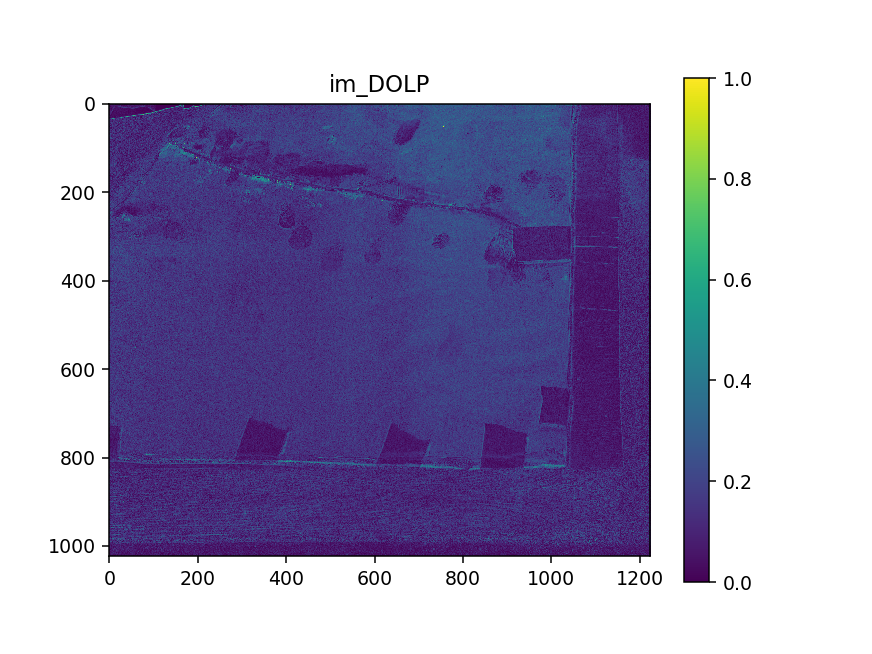

In [263]:
%matplotlib notebook
print(im_DOLP.shape)
plt.imshow(im_DOLP)
plt.title('im_DOLP')
plt.colorbar()

(1024, 1224)


<IPython.core.display.Javascript object>


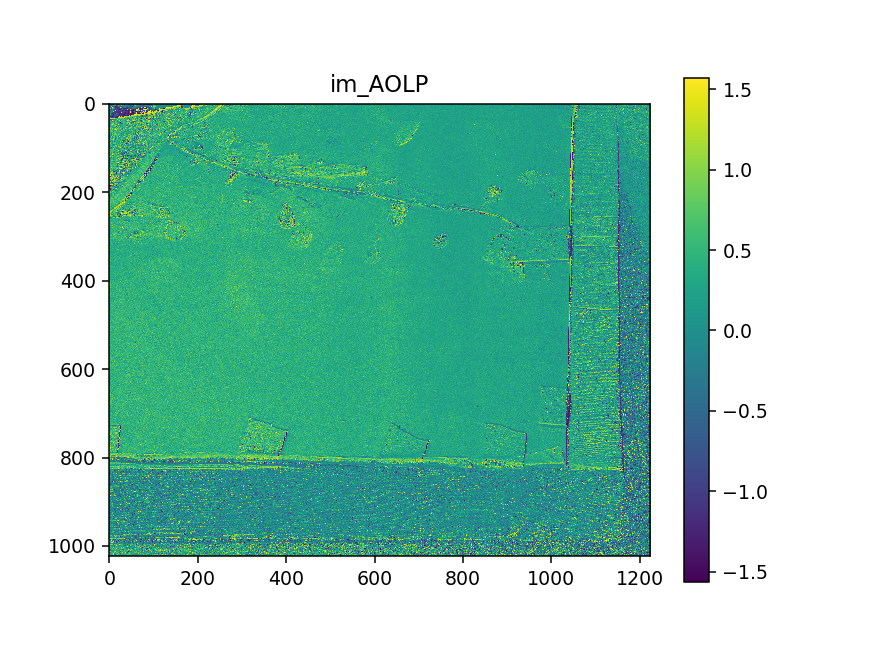

In [264]:
%matplotlib notebook
print(im_AOLP.shape)
plt.imshow(im_AOLP)
plt.title('im_AOLP')
plt.colorbar()

<IPython.core.display.Javascript object>


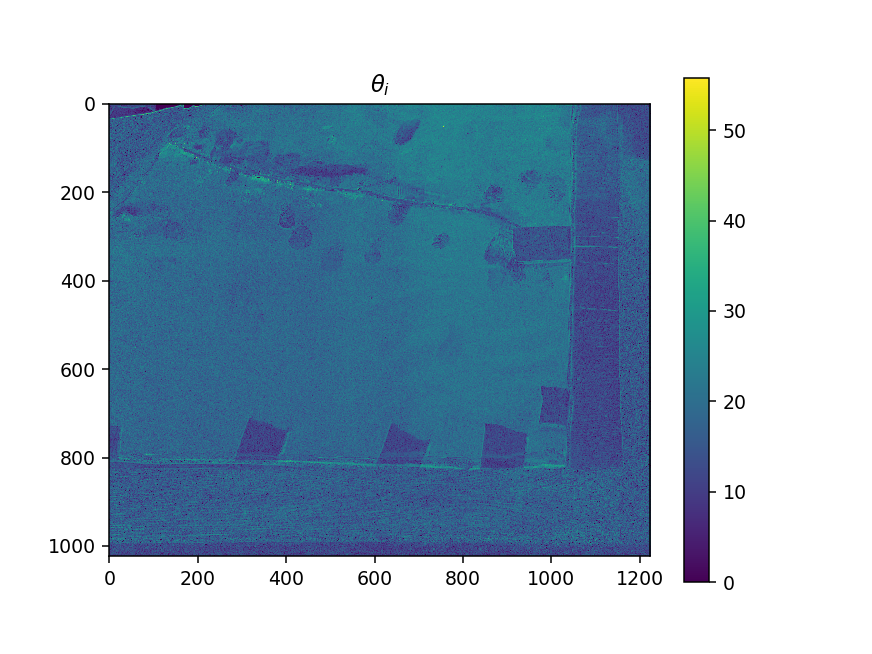

In [266]:
%matplotlib notebook
plt.imshow(im_theta)
plt.title('$\\theta_i$')
plt.colorbar()

In [259]:
im_theta

array([[10.7104911 , 10.87388765,  9.06560177, ..., 11.09256904,
        10.67872657, 12.8811599 ],
       [11.16340127,  6.91958512, 12.8126737 , ..., 13.18826619,
        13.66490727, 10.17517805],
       [14.56727284, 20.37067293, 18.17400558, ...,  9.32059776,
        13.89936032, 15.0523951 ],
       ...,
       [13.20372682,  6.40562638,  8.72821669, ..., 14.13608187,
        13.8957466 ,  7.53933925],
       [13.25725347, 14.47771903, 11.72495608, ..., 10.8927637 ,
        10.44563772, 14.88176074],
       [13.48335806,  8.00039639, 15.90396175, ..., 12.55697889,
        13.02596219, 16.13365685]])

<IPython.core.display.Javascript object>


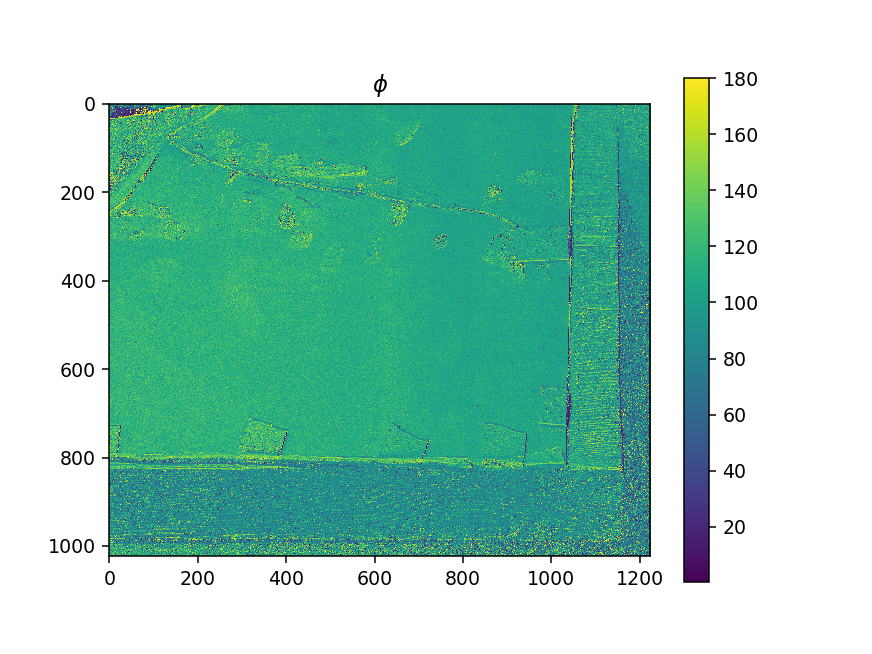

In [267]:
%matplotlib notebook
plt.imshow(im_phi)
plt.title('$\\phi$')
plt.colorbar()